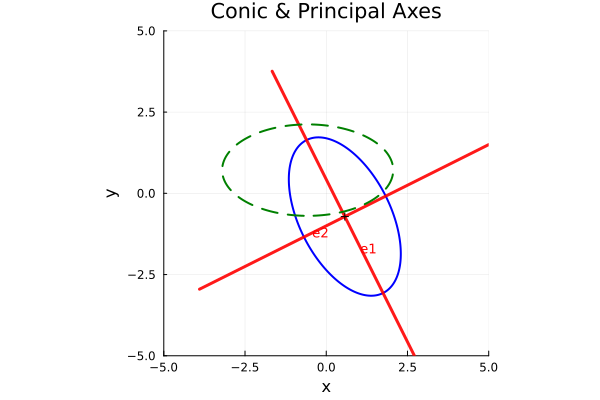

In [26]:
using LinearAlgebra, Plots, StaticArrays

# --- Conic helpers -----------------------------------------------------------
"Symmetric 3×3 matrix for ax^2 + bxy + cy^2 + dx + ey + f = 0"
conic_matrix(a, b, c, d, e, f) = [
    a    b/2  d/2;
    b/2  c    e/2;
    d/2  e/2  f
]

@inline qval(Q, x, y) = begin
    v = SVector{3}(x, y, 1.0)  # fast small-vector; remove SVector if StaticArrays not installed
    # If you don't have StaticArrays, replace previous line with: v = [x, y, 1.0]
    dot(v, Q * v)
end

function contour0!(Q; xlims=(-5,5), ylims=(-5,5), n=500, kwargs...)
    xs = range(xlims[1], xlims[2]; length=n)
    ys = range(ylims[1], ylims[2]; length=n)
    Z  = [ qval(Q, x, y) for y in ys, x in xs ]     # Matrix (length(ys) × length(xs))
    contour!(xs, ys, Z; levels=[0], aspect_ratio=1, kwargs...)
end

"Center of a non-degenerate conic (ellipse/hyperbola) solving A*x0 = -b"
function conic_center(Q)
    A = Symmetric(Q[1:2, 1:2])      # quadratic 2×2 block
    b = Q[1:2, 3]                   # = [d/2, e/2]
    x0 = -A \ b
    return x0
end

"Build affine 3×3 from rotation R (2×2) and translation t (2)"
affine(R, t) = [R  t; 0 0 1]

"Transform conic Q under x = H * u → Q_u = H' * Q * H"
transform_conic(Q, H) = H' * Q * H

# --- Plot everything: original, principal axes, and axis-aligned version -----
function overlay_conic_with_principal_axes(Q; xlims=(-5,5), ylims=(-5,5), n=500)
    # 1) Original
    plt = plot(; xlim=xlims, ylim=ylims, aspect_ratio=1, legend=false, title="Conic & Principal Axes")

    contour0!(Q; xlims=xlims, ylims=ylims, n=n, linewidth=2, linecolor=:blue, label="Original conic")

    # 2) Center and principal axes (eigenvectors of A)
    A = Symmetric(Q[1:2, 1:2])
    x0 = conic_center(Q)                   # translation that removes linear terms
    F  = eigen(A)                          # A = V * Diagonal(λ) * V'
    V  = F.vectors                         # columns are orthonormal eigenvectors
    λ  = F.values

    # Plot axes through the center
    scale = maximum(xlims .∪ ylims)        # a visible length
    for i in 1:2
        v = V[:, i] ./ norm(V[:, i])
        p1 = x0 +  v .* scale
        p2 = x0 -  v .* scale
        plot!([p1[1], p2[1]], [p1[2], p2[2]]; color=:red, lw=3, label=(i==1 ? "Principal axes" : ""), alpha=0.9)
        # Small label a bit away from center along the axis
        annotate!(x0[1] + 1.1*v[1], x0[2] + 1.1*v[2], text("e$(i)", :red, 9, :left))
    end
    scatter!([x0[1]], [x0[2]]; color=:black, markershape=:cross, label="Center")

    # 3) Build an axis-aligned conic with same center & eigenvalues
    #    Steps: translate to center (t = x0) and rotate into eigenbasis (R=V),
    #    giving Q' = H' Q H that is diagonal in its 2×2 block and has zero linear terms.
    H_to_principal = affine(V, x0)
    Qp = transform_conic(Q, H_to_principal)

    # Clean tiny numerical noise so it's visually axis-aligned
    Qp_clean = copy(Qp)
    for i in 1:3, j in 1:3
        abs(Qp_clean[i,j]) < 1e-10 && (Qp_clean[i,j] = 0.0)
    end

    # Keep only the diagonal quadratic terms (λ1, λ2) and constant f'
    Q_axis = Diagonal([Qp_clean[1,1], Qp_clean[2,2], Qp_clean[3,3]])

    # Map that back by translation only (no rotation) so it's centered at x0 but aligned with x/y
    H_back = affine(I(2), x0)
    Q_aligned = transform_conic(Q_axis, H_back)

    contour0!(Q_aligned; xlims=xlims, ylims=ylims, n=n,
              linewidth=2, linecolor=:green, linestyle=:dash, label="Axis-aligned (principal frame)")

    xlabel!("x"); ylabel!("y")
    return plt
end

# --- Example: tilted ellipse with linear terms (shifted center) --------------
a, b, c, d, e, f = 6.0, 4.0, 3.0, -4.0, 2.0, -12.0

# --- Circle example ---
# r = 20.0
# a, b, c, d, e, f = 1.0, 0.0, 1.0, -4.0, 4.0, -r^2

# Hyperbola example: x^2/4 - y^2 = 1
# a, b, c, d, e, f = 0.25, -1.0, -1.0, -4.0, 2.0, -1.0

Q = conic_matrix(a, b, c, d, e, f)
plt = overlay_conic_with_principal_axes(Q; xlims=(-5, 5), ylims=(-5, 5), n=600)
display(plt)
